---
title: "2.5D IP Inversion"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Keywords:** induced polarization, 2.5D inversion, sparse norm, tree mesh.

</br>

**Summary:** Here we invert IP data to recover the subsurface chargeability distribution on a tree mesh. We demonstrate two inversion approaches for recovering a chargeability model:

1. Weighted least-squares inversion
2. Iteratively re-weighted least-squares (IRLS) inversion

Almost all of the details of defining and carrying out weighted least-squares and iteratively weighted least squares inversion were covered in the [2.5D DC Resistivity Inversion](fwd_dcr_2d.ipynb) tutorial. And functionality specific to defining the IP forward simulation was covered in the [2.5D IP Forward Simulation](fwd_dcr_2d.ipynb) tutorial. As we will focus primarily on content specific to IP inversion, we strongly urge the reader to work through the aforementioned tutorials prior to working through this one.

</br>

**Learning Objectives:**

- Assigning appropriate uncertainties to IP data
- Designing a mesh for IP inversion
- Obtaining a background conductivity/resistivity model for the IP inversion
- Analyzing inversion results

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to IP is imported from [simpeg.electromagnetics.static.induced_polarization](xref:simpeg#simpeg.electromagnetics.static.induced_polarization).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from simpeg.utils import download, model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

## Load and Plot Tutorial Data

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/06-ip/inv_ip_2d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_2d.txt"
data_filename = dir_path + "ip_data.obs"

   saved to: /home/ssoler/git/user-tutorials/notebooks/06-ip/inv_ip_2d_files.tar.gz
Download completed!


/tmp/ipykernel_978590/2163865962.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


### Load the Topography

True surface topography is defined as an (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray).
For the 2.5D problem geometry however, topography is an (N, 2) [numpy.ndarray](xref:numpy#numpy.ndarray), where the first coordinate represent along-line position and the second coordinate represents the vertical position. In this tutorial, we assume the topography and electrode locations are defined according to the 2.5D geometry.

In [3]:
# Load 2D topography
topo_2d = np.loadtxt(str(topo_filename))

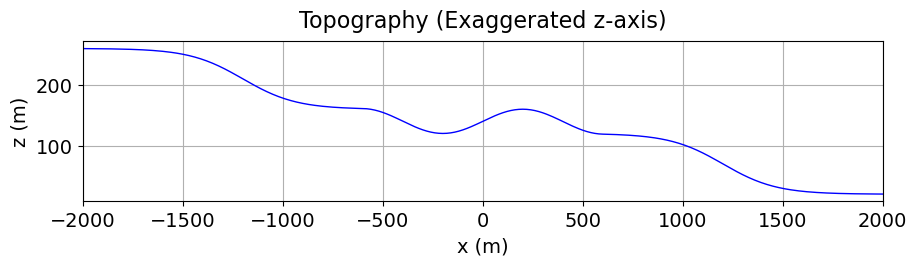

In [4]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, -1], color="b", linewidth=1)
ax.set_xlim([topo_2d[:, 0].min(), topo_2d[:, 0].max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

### Load the IP Data

**Option A: DCIP2D formatted data**

For this tutorial, the observed data are organized with a UBC-GIF DCIP2D formatted data file. We can use the [read_dcip2d_ubc](xref:simpeg#simpeg.utils.io_utils.read_dcip2d_ubc) utility function to load data in this format. This function outputs a SimPEG [Data](xref:simpeg#simpeg.data.Data) object. The data are apparent chargeabilities in V/V.

In [5]:
ip_data = read_dcip2d_ubc(data_filename, "apparent_chargeability", "general")

**Option B: Survey from ABMN electrode locations**

If you have CSV-formatted data containing the ABMN electrode locations, you will need to:

* load the file into a [numpy.ndarray](xref:numpy#numpy.ndarray)
* extract the data column and the A, B, M and N electrode locations
* transform the electrode locations to the 2.5D geometry if necessary; i.e. (N, 2) [numpy.ndarray](xref:numpy#numpy.ndarray)
* use the [generate_survey_from_abmn_locations](xref:simpeg#simpeg.electromagnetics.static.utils.generate_survey_from_abmn_locations) to generate a [survey](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey) object automatically.
* Define a [Data](xref:simpeg#simpeg.data.Data) object attached to the survey and observed data.

E.g. for a file containing electrode locations already formatted for a 2.5D geometry:
```
data_array = np.loadtxt(data_filename, skiprows=1)

dobs = data_array[:, -1]
A = data_array[:, 0:2]
B = data_array[:, 2:4]
M = data_array[:, 4:6]
N = data_array[:, 6:8]

survey = generate_survey_from_abmn_locations(
    locations_a=A,
    locations_b=B,
    locations_m=M,
    locations_n=M,
    data_type='apparent_chargeability'
)

dc_data = data.Data(survey, dobs=dobs)
```

### Plot IP Data in Pseudo-Section

Here we use the [plot_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_pseudosection) utility function to represent the observed apparent chargeability data in pseudosection. In this case, the apparent chargeabilities are represented in V/V.

**In the case of secondary voltage data,** you would need to convert the values to apparent chargeabilities. This accomplished by normalizing the secondary IP voltages by the DC voltages.

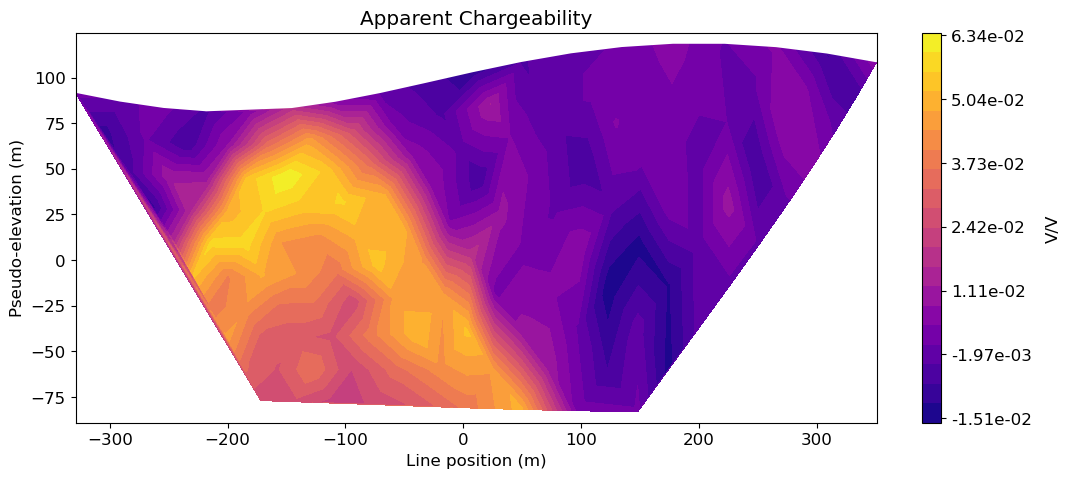

In [6]:
# Plot apparent conductivity using pseudo-section
mpl.rcParams.update({"font.size": 12})

apparent_chargeability = ip_data.dobs

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    ip_data.survey,
    apparent_chargeability,
    "contourf",
    ax=ax1,
    scale="linear",
    cbar_label="V/V",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.plasma},
)
ax1.set_title("Apparent Chargeability")
plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For secondary voltage data,** we generally apply a percent uncertainty and a very small floor uncertainty to all data. Differences in electrode spacing and subsurface conductivity result in secondary voltage IP data that span many orders of magnitude. A percent uncertainty ensures all data are fit equally. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages.

**For apparent chargeability data,** we generally apply a floor uncertainty to all data. This is because apparent chargeability data is obtained by normalizing the secondary voltage defining the IP signature by the DC voltage. This effectively removes the influence of electrode spacing on the amplitude of the datum. Here, we apply a floor uncertainty of 5e-3 V/V to all data.

In [7]:
ip_data.standard_deviation = 5e-3 * np.ones_like(ip_data.dobs)

## Design a (Tree) Mesh

IP inversion is carried out on the same mesh that is used for DC resistivity inversion. Here, we reproduce the survey-based meshing approach that was used in the  [2.5D Inversion of DC Resistivity Data](../05-dcr/inv_dcr_2d.ipynb) tutorial. The best-practices for meshes design for DC/IP problems is provided in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial.

**Tutorial mesh:** Here, a minimum cell width of 4 m (or 1/10 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 400 m, so a the padding was extended at least 1200 m from the survey region. Using the [refine_surface](xref:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](xref:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](xref:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [8]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, topo_2d[:, -1].max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = ip_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

## Define the Active Cells

Use the [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function to obtain the indices of the active mesh cells from topography (e.g. cells below surface).

In [9]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Project Electrodes to Discretized Topography

Surface IP data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to inverting surface IP data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [10]:
ip_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the Background Conductivity/Resistivity

In order to invert IP data, we require the background conductivity/resistivity model. **In practice,** a conductivity/resistivity model is recovered by inverting DC resistivity data; see the [2.5D Inversion of DC Resistivity Data](../05-dcr/inv_dcr_2d.ipynb) tutorial. Since the conductivity/resistivity model greatly impacts the sensitivities for the IP problem, IP inversion is most successful when the recovered conductivity/resistivity model accurately characterizes the true subsurface distribution of electrical properties.

**For the tutorial,** we will demonstrate the importance of using an appropriate background conductivity model for IP inversion. For our weighted least-squares inversion approach, we use a halfspace as the background conductivity model. For the iteratively re-weighted least-squares inversion approach, we use the true subsurface conductivity model. In both cases, the model is defined on the active mesh cells, and we must use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) mapping to map from the model space to the conductivities on the entire mesh.

In [11]:
# Define electrical conductivities in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [12]:
# Define halfspace conductivity model
halfspace_conductivity_model = background_conductivity * np.ones(n_active)

# Define true conductivit model
true_conductivity_model = halfspace_conductivity_model.copy()

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
true_conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, 72.0], 60.0, mesh.cell_centers[active_cells, :]
)
true_conductivity_model[ind_resistor] = resistor_conductivity

In [13]:
# Mapping from conductivity model to conductivity on all cells
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

In [14]:
# Mapping to neglect air cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

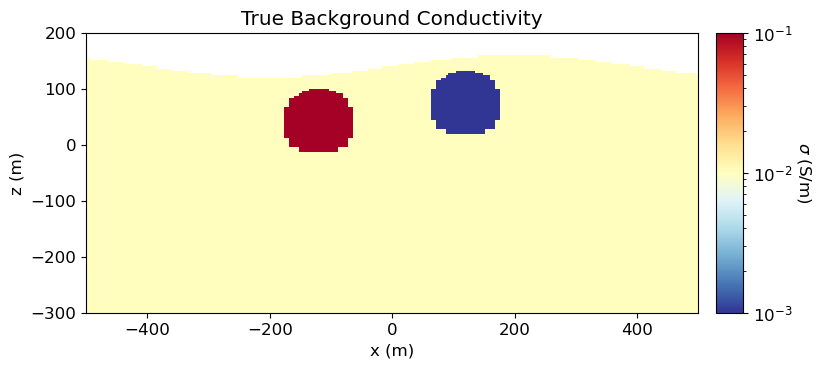

In [15]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * true_conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("True Background Conductivity")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

## Weighted Least-Squares Inversion

Here, a weighted least-squares inversion approach is used to apparent chargeability data to recover an intrinsic chargeability model.

### Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](xref:numpy#numpy.ndarray)) to the physical property values of all cells in the mesh. Mappings are created using the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module.

SimPEG uses a linearized formulation for simulating IP data; see [Simulation2DCellCentered](xref:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DCellCentered) or [Simulation2DNodal](xref:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal). In this formulation, any standard definition of the chargeability can be inverted. And the units of the recovered chargeability values is the same as the data units; e.g. intrinsic chargeability (V/V or mV/V) or integrated chargeability (ms). If you are inverting secondary voltages however, the chargeability model must represent intrinsic chargeabilities ($0 \leq \eta \leq 1$) in V/V.

**In this tutorial,** the model parameters are the subsurface chargeabilities ($0 \leq \eta \leq 1$) in V/V. We use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) map to project the active cell chargeabilities to the entire mesh. 

In [16]:
chargeability_map = maps.InjectActiveCells(mesh, active_cells, 0.0)

### Starting and Reference Models for IP Inversion

Here, we would create starting and/or reference models for the IP inversion as well as the mapping from the model space to the active cells. Starting and reference models can be a constant background value or contain a-priori structures. Here, the starting model is the 1e-6 V/V. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration.

In [17]:
# Create starting model from log-conductivity
starting_chargeability_model = 1e-6 * np.ones(n_active)

# Zero reference conductivity model
reference_chargeability_model = np.zeros_like(starting_chargeability_model)

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 2.5D IP was discussed in the [2.5D IP Forward Simulation](fwd_dcip_2d.ipynb) tutorial. Here, we use the [Simulation2DNodal](xref:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal) simulation which solves for the electric potential on mesh nodes.

Since we are using a background *conductivity* model, we use ``sigma`` to define the background conductivity on the entire mesh. Because the IP problem has been linearized, we store the sensitivities for the inversion using ``storeJ``.

In [18]:
simulation_L2 = ip.Simulation2DNodal(
    mesh,
    survey=ip_data.survey,
    sigma=conductivity_map * halfspace_conductivity_model,
    etaMap=chargeability_map,
    storeJ=True,
)

### Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [19]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=ip_data)

### Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](xref:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Length scales along x and y are used to balance the smallness and smoothness terms. Here, length scales of 5 are used to emphasize more smoothness in the recovered model. The reference model is only applied to the smallness term.

By default, the regularization acts on the model parameters; which in the case are the chargeabilities of the active cells. So we need to specify which cells are active in the regularization. And if we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [20]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    length_scale_x=5.0,
    length_scale_y=5.0,
    reference_model=reference_chargeability_model,
    reference_model_in_smooth=False,
)

### Define the Optimization Algorithm

Here, we use the [ProjectedGNCG](xref:simpeg#simpeg.optimization.ProjectedGNCG) class to solve the optimization problem using projected Gauss-Newton with conjugate gradietn solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches. Here, the `lower` property is set to 0 to ensure recovered chargeability values are positive.

In [21]:
opt_L2 = optimization.ProjectedGNCG(
    maxIter=40, lower=0.0, maxIterLS=20, maxIterCG=20, tolCG=1e-2
)

### Define the Inverse Problem

We use the [BaseInvProblem](xref:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [22]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Provide Inversion Directives

Directives represent operations that are applied while the inversion is running. Here, we apply common directives for weighted least-squares inversion of IP data and describe their roles. These are:

- [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights): Apply sensitivity weighting to counteract the natural tendency of IP inversion to place materials near the electrodes. Since the IP problem has been linearized, we do not need to update the sensitivities and we set `every_iteration=False`. For IP inversion, we do not want to use the entire dynamic range of the sensitivities to generate our weighting. So we generally set `threshold_value` to a value betwewen 1e-4 and 1e-1.

- [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=False` because the ideal preconditioner because the forward problem and regularization are not model-dependent.

- [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 2 or 3 works well for DC resistivity inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [23]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=False, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=False)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=20)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](xref:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [24]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# recovered_model_L2 = inv_L2.run(np.log(0.01) * np.ones(n_param))
recovered_chargeability_L2 = inv_L2.run(starting_chargeability_model)


Running inversion with SimPEG v0.24.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.12/site-packages/simpeg/base/pde_simulation.py:490: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.12/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:768: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.12/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:795: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.12/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.59e+01  4.04e+03  8.40e-08  4.04e+03    6.03e+03      0              


   1  7.59e+01  3.13e+02  3.58e+00  5.84e+02    6.54e+02      0              


   2  3.79e+01  2.80e+02  3.78e+00  4.24e+02    5.57e+02      0   Skip BFGS  


   3  3.79e+01  2.14e+02  4.86e+00  3.98e+02    2.27e+02      0              


   4  1.90e+01  2.14e+02  4.84e+00  3.06e+02    2.15e+02      0              


   5  1.90e+01  1.78e+02  6.15e+00  2.95e+02    3.76e+01      0              


   6  9.48e+00  1.78e+02  6.13e+00  2.37e+02    1.34e+02      0              


   7  9.48e+00  1.54e+02  7.96e+00  2.30e+02    2.40e+01      0              


   8  4.74e+00  1.54e+02  7.92e+00  1.92e+02    9.00e+01      0              


   9  4.74e+00  1.36e+02  1.06e+01  1.87e+02    1.68e+01      0              


  10  2.37e+00  1.36e+02  1.06e+01  1.62e+02    6.03e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.0459e+02
0 : |xc-x_last| = 4.6013e-01 <= tolX*(1+|x0|) = 1.0001e-01
0 : |proj(x-g)-x|    = 6.0336e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.0336e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =     11
------------------------- DONE! -------------------------


### Plot the Data Misfit

This step is necessary for determining whether the recovered model accurately reproduces observed anomalies. Here, we plot the observed data, predicted data for the recovered model, and the data misfit. As we can see, the recovered model reproduces the observed data quite well. And the data misfit map indicates we are not overfitting certain electrodes relative to others. We applied a uniform floor uncertainty to all data. However, if the uncertainty on each datum is different, we may choose to plot the normalized data misfit; i.e. the misfit normalized by the uncertainties.

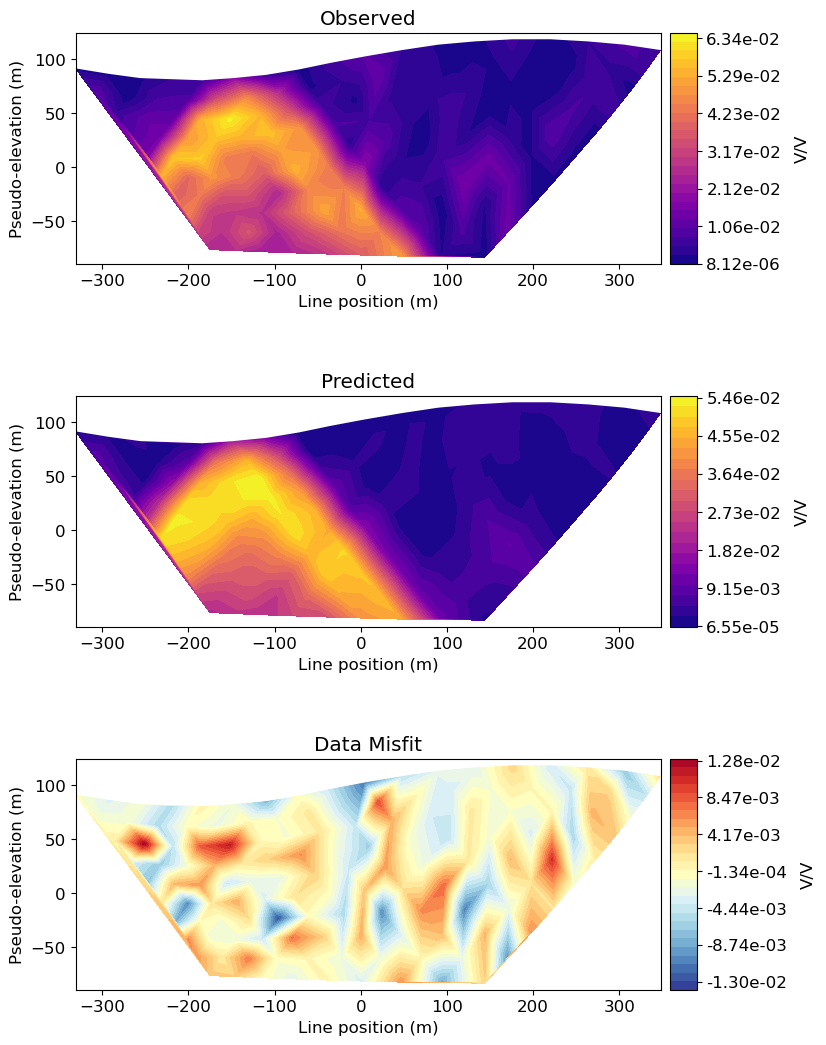

In [25]:
# Predicted data from recovered model
dpred = inv_prob_L2.dpred
dobs = ip_data.dobs
std = ip_data.standard_deviation

# Plot
fig = plt.figure(figsize=(9, 11))
data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred)]
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["V/V", "V/V", "V/V"]
scale = ["linear", "linear", "lindear"]
cmap_list = [mpl.cm.plasma, mpl.cm.plasma, mpl.cm.RdYlBu_r]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        ip_data.survey,
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

### Plot the Recovered Model

As we can see, the inversion recovers a smooth model. We recover a confined chargeable structure centered at (-160, 50). We also recover an extreme chargeable feature at depth at x < 0 m. Where sensitivity is low, we expect the inversion to default to the reference model values (i.e. zero) given the regularization we chose. As we will see, the second feature is an artifact of choosing an inappropriate background conductivity model

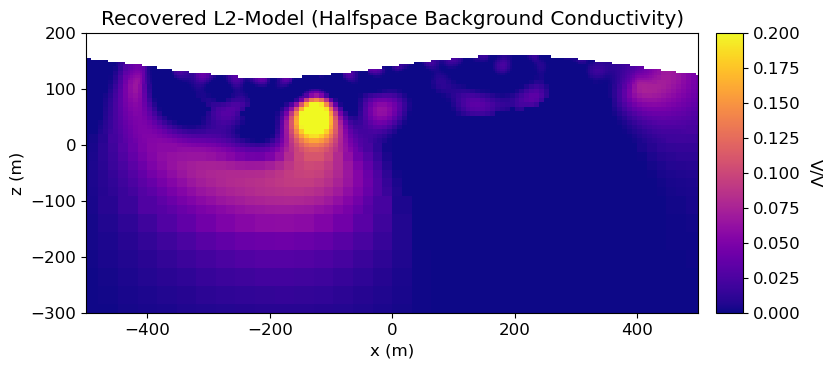

In [26]:
fig = plt.figure(figsize=(9, 4))

norm = Normalize(vmin=0.0, vmax=0.2)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_chargeability_L2,
    normal="Y",
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.plasma},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Recovered L2-Model (Halfspace Background Conductivity)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("V/V", rotation=270, labelpad=15, size=12)

plt.show()

## Iteratively Re-weighted Least-Squares Inversion

Here, we provide a step-by-step best-practices approach for IRLS inversion of apparent chargeability data on a tree mesh to recover a chargeability model. Many of the steps are the same as our previous approach. As a result, we will avoid repeating information whenever possible. It should be noted that once the IRLS inversion is complete, we can extract the least-squares model the is recovered prior to performing the IRLS step. This will be done to compare least-squares inversion results for poor and appropriate background conductivity models. 

Because we are changing the background conductivity, the sensitivities used for the L2 inversion cannot be reused for the IRLS inversion. Here, we define the simulation that can be used for the IRLS inversion, where the true background conductivity is true.

In [27]:
simulation_irls = ip.Simulation2DNodal(
    mesh,
    survey=ip_data.survey,
    sigma=conductivity_map * true_conductivity_model,
    etaMap=chargeability_map,
    storeJ=True,
)

### Define the Data Misfit

In [28]:
dmis_irls = data_misfit.L2DataMisfit(simulation=simulation_irls, data=ip_data)

### Define the Regularization

Here, we use the [Sparse](xref:simpeg#simpeg.regularization.Sparse) regularization class to constrain the inversion result using an IRLS approach. Length scales along x and y are used to balance the smallness and smoothness terms. We use the same length scales that were used in the weighted least-squares inversion. Here, we apply a 0-norm on the smallness and a 2-norm on the smoothness.

In [29]:
reg_irls = regularization.Sparse(
    mesh,
    active_cells=active_cells,
    length_scale_x=5.0,
    length_scale_y=5.0,
    norms=[0, 2, 2],
    reference_model=reference_chargeability_model,
    reference_model_in_smooth=False,
)

### Define the Optimization

In [30]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=40, lower=0.0, maxIterLS=20, maxIterCG=20, tolCG=1e-2
)

### Define the Inverse Problem

In [31]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Provide Inversion Directives

Here, we create common directives for IRLS inversion of IP data and describe their roles. In additon to the [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights), [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner) and [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig)  (described before), inversion with sparse-norms requires the [`UpdateIRLS`](xref:simpeg#simpeg.directives.UpdateIRLS) directive. Note that `every_iteration` has been set to ``True`` for the Jacobi preconditioner. This is because the IRLS regularization is model-dependent.

You will notice that we don't use the [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule) and [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit) directives. Here, the beta cooling schedule is set in the [`UpdateIRLS`](xref:simpeg#simpeg.directives.UpdateIRLS) directive using the `coolingFactor` and `coolingRate` properties. The target misfit for the L2 portion of the IRLS approach is set with the `chifact_start` property. 

In [32]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(
    every_iteration=False, threshold_value=1e-2
)
update_irls = directives.UpdateIRLS(
    cooling_factor=2,
    cooling_rate=2,
    f_min_change=1e-4,
    max_irls_iterations=30,
    chifact_start=1.0,
)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=20)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
]

### Define and Run the Inversion

In [33]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_chargeability_irls = inv_irls.run(starting_chargeability_model)


Running inversion with SimPEG v0.24.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.79e+01  4.04e+03  8.43e-08  4.04e+03    8.08e+03      0              


   1  6.79e+01  1.67e+02  2.64e+00  3.46e+02    3.44e+02      0              


   2  3.40e+01  1.48e+02  2.78e+00  2.43e+02    2.78e+02      0   Skip BFGS  


Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.11207883969010549
   3  3.40e+01  1.29e+02  4.20e+00  2.72e+02    4.85e+01      0              


   4  3.40e+01  1.30e+02  4.07e+00  2.68e+02    2.53e+01      0              


   5  3.40e+01  1.30e+02  4.51e+00  2.83e+02    1.97e+01      1   Skip BFGS  


   6  3.40e+01  1.31e+02  4.46e+00  2.82e+02    8.99e+00      0              


   7  3.40e+01  1.31e+02  4.73e+00  2.91e+02    9.42e+00      0              


   8  3.40e+01  1.31e+02  4.70e+00  2.90e+02    4.40e+00      0              


   9  3.40e+01  1.31e+02  4.87e+00  2.97e+02    1.15e+01      0              


  10  3.40e+01  1.31e+02  4.84e+00  2.95e+02    4.67e+00      0              


  11  3.40e+01  1.31e+02  4.95e+00  2.99e+02    1.40e+01      0              


  12  3.40e+01  1.31e+02  4.91e+00  2.98e+02    4.67e+00      0              


  13  3.40e+01  1.31e+02  4.97e+00  3.00e+02    1.52e+01      0              


  14  3.40e+01  1.31e+02  4.92e+00  2.98e+02    5.28e+00      0              


  15  3.40e+01  1.31e+02  4.92e+00  2.98e+02    1.68e+01      0              


  16  3.40e+01  1.31e+02  4.87e+00  2.97e+02    9.10e+00      0              


  17  3.40e+01  1.31e+02  4.81e+00  2.95e+02    1.92e+01      0              


  18  3.40e+01  1.32e+02  4.76e+00  2.94e+02    7.75e+00      0              


  19  3.40e+01  1.32e+02  4.66e+00  2.90e+02    1.99e+01      0              


  20  3.40e+01  1.33e+02  4.61e+00  2.89e+02    3.72e+00      0              


  21  3.40e+01  1.33e+02  4.47e+00  2.84e+02    2.07e+01      0              


  22  3.40e+01  1.33e+02  4.43e+00  2.84e+02    3.27e+00      0              


  23  3.40e+01  1.33e+02  4.27e+00  2.78e+02    2.29e+01      0              


  24  3.40e+01  1.34e+02  4.23e+00  2.78e+02    2.44e+00      0              


  25  3.40e+01  1.34e+02  4.06e+00  2.72e+02    2.43e+01      0              


  26  3.40e+01  1.35e+02  4.02e+00  2.72e+02    3.15e+00      0              


  27  3.40e+01  1.35e+02  3.85e+00  2.66e+02    2.55e+01      0              


  28  3.40e+01  1.36e+02  3.82e+00  2.65e+02    3.38e+00      0              


  29  3.40e+01  1.36e+02  3.65e+00  2.60e+02    2.71e+01      0              


  30  3.40e+01  1.36e+02  3.61e+00  2.59e+02    1.38e+00      0              


  31  3.40e+01  1.36e+02  3.45e+00  2.54e+02    3.13e+01      0              


  32  3.40e+01  1.37e+02  3.42e+00  2.53e+02    8.27e-01      0              


  33  3.40e+01  1.37e+02  3.26e+00  2.48e+02    3.86e+01      0              


  34  3.40e+01  1.37e+02  3.24e+00  2.47e+02    2.45e-01      0              


  35  3.40e+01  1.37e+02  3.07e+00  2.42e+02    4.75e+01      0              


  36  3.40e+01  1.38e+02  3.05e+00  2.41e+02    4.13e-01      0              


  37  3.40e+01  1.38e+02  2.89e+00  2.36e+02    5.60e+01      0              


  38  3.40e+01  1.38e+02  2.87e+00  2.35e+02    5.06e-01      0              


  39  3.40e+01  1.38e+02  2.71e+00  2.30e+02    6.23e+01      0              


  40  3.40e+01  1.38e+02  2.69e+00  2.29e+02    6.62e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 7.7146e-01 <= tolF*(1+|f0|) = 4.0459e+02
1 : |xc-x_last| = 4.3895e-02 <= tolX*(1+|x0|) = 1.0001e-01
0 : |proj(x-g)-x|    = 6.6159e-01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.6159e-01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      40    <= iter          =     40
------------------------- DONE! -------------------------


## Plot True, L2 and IRLS Models

Here, we compare the models recovered from weighted least-squares and iteratively re-weighted least-squares inversion to the true model. As we will see, the L2-model extracted from the IRLS inversion is a great improvement over the L2-model we recovered via weighted least-squares inversion. And the only difference is the background conductivity model.

In [34]:
# Recreate True Model on a Tensor Mesh
true_background_chargeability = 0.0
true_conductor_chargeability = 1e-1

true_chargeability_model = true_background_chargeability * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
true_chargeability_model[ind_conductor] = true_conductor_chargeability

In [35]:
# Extract the L2 Model from the IRLS Inversion
recovered_chargeability_L2_good = inv_prob_irls.l2model

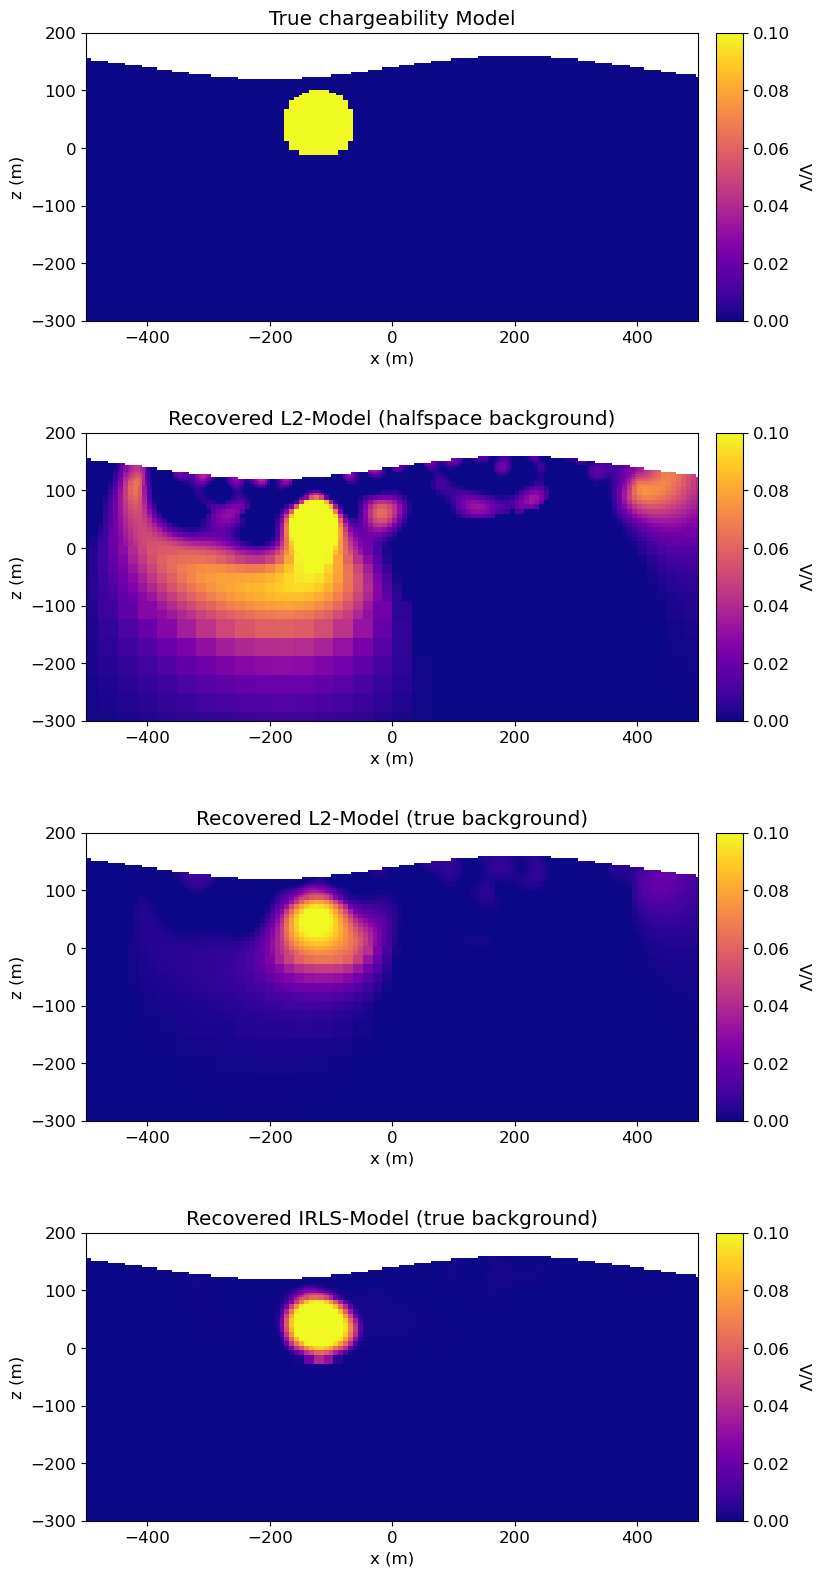

In [36]:
norm = Normalize(vmin=0.0, vmax=0.1)

fig = plt.figure(figsize=(9, 16))
ax1 = 4 * [None]
ax2 = 4 * [None]
title_str = [
    "True chargeability Model",
    "Recovered L2-Model (halfspace background)",
    "Recovered L2-Model (true background)",
    "Recovered IRLS-Model (true background)",
]
plotting_model = [
    true_chargeability_model,
    recovered_chargeability_L2,
    recovered_chargeability_L2_good,
    recovered_chargeability_irls,
]

for ii in range(0, 4):
    ax1[ii] = fig.add_axes([0.14, 0.78 - 0.25 * ii, 0.68, 0.18])
    mesh.plot_image(
        plotting_map * plotting_model[ii],
        ax=ax1[ii],
        grid=False,
        pcolor_opts={"norm": norm, "cmap": mpl.cm.plasma},
    )
    ax1[ii].set_xlim(-500, 500)
    ax1[ii].set_ylim(-300, 200)
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")

    ax2[ii] = fig.add_axes([0.84, 0.78 - 0.25 * ii, 0.03, 0.18])
    cbar = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar.set_label("V/V", rotation=270, labelpad=15, size=12)

plt.show()